# Feature Selection Demo with `Scikit-Learn`

## PIMA Indians Diabetes Dataset

In this tutorial, I will use the "PIMA Indian Diabetes" dataset, where all
patients are females at least 21 years old of Pima Indian heritage.

The classification task is to predict whether an individual has diabetes from
the following features:

1. *Pregnancies:* Number of times pregnant 
2. *Glucose:* Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
3. *BloodPressure:* Diastolic blood pressure (mm Hg) 
4. *SkinThickness:* Triceps skin fold thickness (mm) 
5. *Insulin:* 2-Hour serum insulin (mu U/ml) 
6. *BMI:* Body mass index (weight in kg/(height in m)^2) 
7. *DiabetesPedigreeFunction:* Diabetes pedigree function 
8. *Age:* (years) 
9. *Outcome:* Class variable (0 or 1) 

## Utility Functions & Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [57]:
# Imports from third-party libraries
from sklearn.feature_selection import (SelectKBest, chi2, f_classif, mutual_info_classif,
                                       RFECV, SequentialFeatureSelector)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from infoml import utils, CONFIG
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Import bmes
import sys, os; sys.path.append(os.environ['BMESAHMETDIR'])
import bmes

# Classifiers
clf = {
    'DT': DecisionTreeClassifier(random_state=0),
    'QDA': QuadraticDiscriminantAnalysis(),
    'SVM': SVC(kernel='linear', random_state=0),
    'LR': LogisticRegression(random_state=0, solver='liblinear')
}


def crossval(clf, X, y, cv=4):
    scores = cross_val_score(clf, X, y, cv=cv, n_jobs=-1)
    print('--- {}-fold cross-validation accuracy: {:.2f} +/- {:.2f} ---'.format(cv, scores.mean(), scores.std()))
    return scores.mean(), scores.std()

def printfeatscores(selector, features):
    print('--- Scores of the features:')
    
    scores, feats = zip(*sorted(zip(selector.scores_, features), reverse=True))
    for score, feat in zip(scores, feats):
        print('{:<14}'.format(feat) + ': ' + str(round(score, 2)))

In [4]:
# Accelerate scikit-learn
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Download data file(s)

In [13]:
datafile = CONFIG.datadir() / 'pima-indians.csv'
URL = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
utils.downloadurl(URL, datafile);

print('--- First 5 lines of data file')
utils.iohead(datafile, 3)

--- First 5 lines of data file


6,148,72,35,0,33.6,0.627,50,1

1,85,66,29,0,26.6,0.351,31,0

8,183,64,0,0,23.3,0.672,32,1

## Load data

In [41]:
names = ['numpregnancies', 'glucose', 'diastolic', 'tricepskin', 'insulin', 
         'bmi', 'pedigree', 'age', 'hasdiabetes']
df = pd.read_csv(datafile, names=names)

X = df.drop('hasdiabetes', axis=1).values
y = df['hasdiabetes'].values
features = np.array(names[:-1])

df.head()

,numpregnancies,glucose,diastolic,tricepskin,insulin,bmi,pedigree,age,hasdiabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Perform Classification using All Features

In [38]:
print('Decision tree classifier')
crossval(clf['DT'], X, y);

print('Quadratic discriminant analysis')
crossval(clf['QDA'], X, y);

print('Support vector machine')
crossval(clf['SVM'], X, y);

Decision tree classifier
--- 4-fold cross-validation accuracy: 0.72 +/- 0.04 ---
Quadratic discriminant analysis
--- 4-fold cross-validation accuracy: 0.75 +/- 0.01 ---
Support vector machine
--- 4-fold cross-validation accuracy: 0.76 +/- 0.02 ---


## Feature Selection: Filter Methods

For a list of available filter methods, see the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html).

In [39]:
# Using chi-squared test
print("Chi-squared test\n")

selector = SelectKBest(chi2, k=3)
selector.fit(X, y)

printfeatscores(selector, features)

print('--- Data with only the top k features')
X_sub = selector.transform(X)
sub_names = selector.transform([features])[0]
display(pd.DataFrame(X_sub, columns=sub_names).head())

crossval(clf['SVM'], X_sub, y);

Chi-squared test

--- Scores of the features:
insulin       : 2175.57
glucose       : 1411.89
age           : 181.3
bmi           : 127.67
numpregnancies: 111.52
tricepskin    : 53.11
diastolic     : 17.61
pedigree      : 5.39
--- Data with only the top k features


,glucose,insulin,age
0,148.0,0.0,50.0
1,85.0,0.0,31.0
2,183.0,0.0,32.0
3,89.0,94.0,21.0
4,137.0,168.0,33.0


--- 4-fold cross-validation accuracy: 0.74 +/- 0.03 ---


## Recursive Feature Elimination (RFE)

--- Number of features selected: 5
--- Features selected: ['numpregnancies' 'glucose' 'diastolic' 'bmi' 'pedigree']
--- 4-fold cross-validation accuracy: 0.77 +/- 0.02 ---


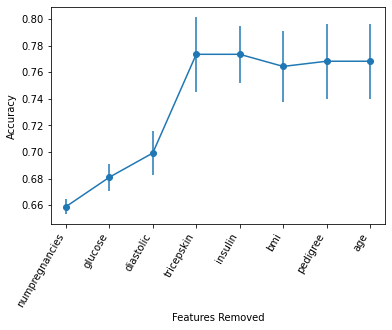

In [56]:
# RFECV usign the SVM classifier would take a long time; let's use a faster 
# method. We will use Logistic Regression instead.
selector = RFECV(clf['LR'], cv=4, scoring='accuracy', n_jobs=-1)
selector.fit(X, y)

print('--- Number of features selected: {}'.format(selector.n_features_))
print('--- Features selected: {}'.format(features[selector.support_]))

# Plot results
N = len(selector.cv_results_['mean_test_score'])
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(range(1, N+1), selector.cv_results_['mean_test_score'],
            yerr=selector.cv_results_['std_test_score'], fmt='o-')
ax.set_xticks(range(1, N+1), features, rotation=60, ha='right')
ax.set_xlabel('Features Removed')
ax.set_ylabel('Accuracy')

# Crossvalidate with the selected features
X_sub = selector.transform(X)
crossval(clf['LR'], X_sub, y);

## Sequential Forward Selection (SFS)

In [67]:
selector = SequentialFeatureSelector(
    clf['LR'], n_features_to_select=7, cv=4, scoring='accuracy', direction="forward", n_jobs=-1
)
selector.fit(X, y)

print('--- Features selected: {}'.format(features[selector.support_]))

--- Features selected: ['numpregnancies' 'glucose' 'diastolic' 'tricepskin' 'insulin' 'bmi'
 'pedigree']


In [ ]:
selector.

In [63]:
selector.get_support()

array([ True,  True,  True, False, False,  True, False, False])